# Example:  Mauna Loa CO2 continued

This GP example shows how to

- Fit fully Bayesian GPs with NUTS
- Model inputs which are themselves uncertain (uncertainty in 'x')
- Defining custom mean and covariance functions
- Semiparametric Gaussian process models

![Earth Systems Research Laboratory](https://www.esrl.noaa.gov/gmd/obop/mlo/pictures/sunsetmaunaloa1.jpg)


# Ice Core Data

The first data set we'll look at is CO2 measurments from ice core data.  This data goes back to the year 13 AD.  The data after the year 1958 is an average of ice core measurments and more accurate data taken from Mauna Loa.   

This data is less accurate than the Mauna Loa atmospheric CO2 measurments.  The dates of the ice core measurements have some uncertainty.  They may be accurate on a yearly level due to how the ice layers on it self every year, but the date isn't likely to be reliable as to the season when the measurment was taken.  Also, the CO2 level observed may be some sort of average of the overall yearly level.  As we saw in the previous example, there is a strong seasonal component in CO2 levels that won't be observable in this data set.

In PyMC3, we can easily include both errors in $y$ and errors in $x$.  To demonstrate this, we remove the latter part of the data (which are averaged with Mauna Loa readings) so we have only the ice core measurements.  We fit the Gaussian process model using the No-U-Turn MCMC sampler.

In [1]:
import pymc3 as pm
import pandas as pd
import numpy as np
import theano
import theano.tensor as tt

import matplotlib.pyplot as plt
%matplotlib inline

/home/bill/anaconda3/envs/pymc3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [2]:
icedata = "/home/bill/Dropbox/projects/maunaloa/merged_ice_core_yearly.csv"
ice = pd.read_csv(icedata, comment='"', header=None)
ice.columns = ["year", "CO2"]
ice["CO2"] = ice["CO2"].astype(np.float)

#### DATA AFTER 1958 is an average of ice core and mauna loa data, so remove it
ice = ice[ice["year"] <= 1958]
print("Number of data points:", len(ice))

Number of data points: 111


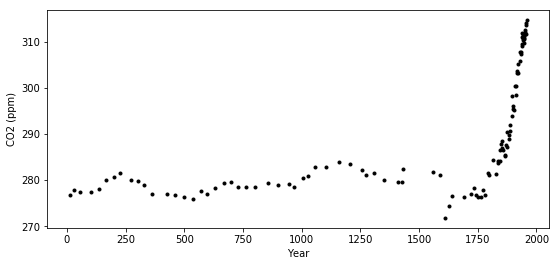

In [3]:
fig = plt.figure(figsize=(9,4))
ax = plt.gca()

ax.plot(ice.year.values, ice.CO2.values, '.k');
ax.set_xlabel("Year")
ax.set_ylabel("CO2 (ppm)");

The industrial revolution era occured around the years 1760 to 1840.  This point is clearly visible in the graph, where CO2 levels rise dramatically after being fairly stationary at around 280 ppm for over a thousand years.

## Uncertainty in 'x'

To model uncertainty in $x$, or time, we place a prior distribution over each of the observation dates.  So that the prior is standardized, we specifically use a PyMC3 random variable to model the difference between the date given in the data set, and it's error.  We assume that these differences are normal with mean zero, and standard deviation of 1 year.

For just the ice core data, the uncertainty in $x$ is not very important.  Later when we include the more accurate Mauna Loa measurments, allowing for this uncertainty will enable us to back-cast seasonal variation.

In [4]:
t = ice.year.values
y = ice.CO2.values

# normalize the CO2 readings prior to fitting the model 
y_mu, y_sd = np.mean(y), np.std(y)
y_n = (y - y_mu) / y_sd

# scale t to have units of centuries
t_n = t / 100

We use an informative prior on the lengthscale that places most of the mass between a few and 20 centuries.

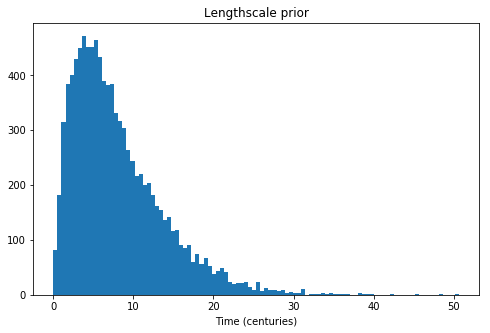

In [5]:
fig = plt.figure(figsize=(8,5))
ax = plt.gca()
ax.hist(pm.Gamma.dist(alpha=2, beta=0.25).random(size=10000), 100)
ax.set_xlabel("Time (centuries)")
ax.set_title("Lengthscale prior");

In [6]:
with pm.Model() as model:
    η = pm.HalfNormal("η", sd=5)
    ℓ = pm.Gamma("ℓ", alpha=2, beta=0.25)
    cov = η**2 * pm.gp.cov.Matern32(1, ℓ)
    gp = pm.gp.Marginal(cov_func=cov)
    
    # x location uncertainty (sd = 0.01 is a standard deviation of one year)
    t_diff = pm.Normal("t_diff", mu=0.0, sd=0.01, shape=len(t))
    t_uncert = t_n - t_diff
    
    # white noise variance
    σ = pm.HalfNormal("σ", sd=5, testval=1)
    y_ = gp.marginal_likelihood("y", X=t_uncert[:,None], y=y_n, noise=σ)

Next we can sample with the NUTS MCMC algorithm.  We run two chains but set the number of cores to one, since the linear algebra libraries used internally by Theano are multicore.

In [7]:
with model:
    tr = pm.sample(500, chains=2, cores=1)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (2 chains in 1 job)
NUTS: [σ, t_diff, ℓ, η]
100%|██████████| 1000/1000 [01:05<00:00, 15.32it/s]
The acceptance probability does not match the target. It is 0.8871619176036385, but should be close to 0.8. Try to increase the number of tuning steps.


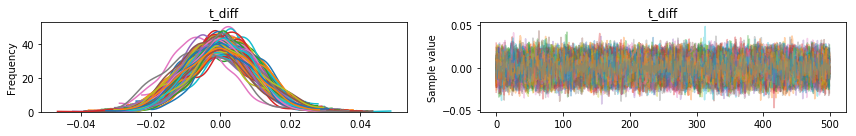

In [8]:
pm.traceplot(tr, varnames=["t_diff"]);

In the traceplot for `t_diff`, we can see that the posterior peaks for the different inputs haven't moved much, but the uncertainty in location is accounted for by the sampling.

The posterior distributions for the other unknown hyperparameters is below.

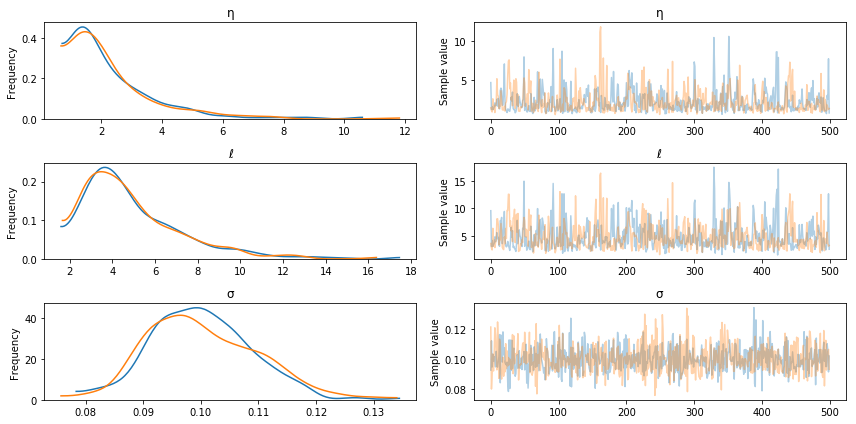

In [9]:
pm.traceplot(tr, varnames=["η", "ℓ", "σ"]);

### Predictions

In [10]:
tnew = np.linspace(-100, 2150, 2000)/100
with model:
    fnew = gp.conditional("fnew", Xnew=tnew[:,None])
    
with model:
    ppc = pm.sample_ppc(tr, samples=500, vars=[fnew])

100%|██████████| 500/500 [02:30<00:00,  3.32it/s]


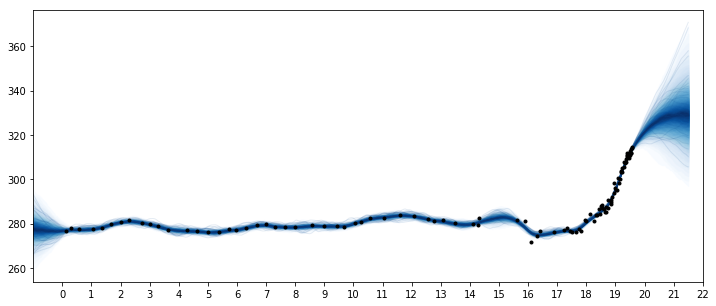

In [11]:
samples = y_sd * ppc["fnew"] + y_mu

fig = plt.figure(figsize=(12,5))
ax = plt.gca()
pm.gp.util.plot_gp_dist(ax, samples, tnew, plot_samples=True, palette="Blues")
ax.plot(t/100, y, "k.");
ax.set_xticks(np.arange(0,23));
ax.set_xlim([-1, 22]);

Two features are apparent in this plot.  One is the [little ice age](https://www.nature.com/articles/ngeo2769), whose effects on CO2 occurs from around 1600 to 1800.  The next is the industrial revolution, when people began releasing large amounts of CO2 into the atmosphere.  


## Semiparametric Gaussian process

The forecast past the latest data point in 1958 rises, then flattens, then dips back downwards.  Should we trust this forecast?  We know it hasn't been born out (see the previous notebook) as CO2 levels have continued to rise.   

We didn't specify a mean function in our model, so we've assumed that our GP has a mean of zero.  This means that
as we forecast into the future, the function will eventually return to zero.  Is this reasonable in this case?  There have been no global events that suggest that atmospheric CO2 will not continue on its current trend.  

### A linear model for changepoints

We adopt the formulation used by [Facebooks prophet](https://peerj.com/preprints/3190.pdf) time series model.  This is a linear peicewise function, where each segments endpoints are restricted to be connect to one another.  Some example functions are plotted below. 

In [12]:
def dm_changepoints(t, changepoints_t):
    A = np.zeros((len(t), len(changepoints_t)))
    for i, t_i in enumerate(changepoints_t):
        A[t >= t_i, i] = 1 
    return A

For later use, we reprogram this function using symbolic theano variables.  The code is a bit inscrutible, but it returns the same thing as `dm_changepoitns` while avoiding the use of a loop.

In [13]:
def dm_changepoints_theano(X, changepoints_t):
    return (0.5 * (1.0 + tt.sgn(tt.tile(X, (1,len(changepoints_t))) - changepoints_t)))

From looking at the graph, some possible locations for changepoints are at 1600, 1800 and maybe 1900.  These bookend the little ice age, the start of the industrial revolution, and the start of more modern industrial practices.

In [14]:
changepoints_t = np.array([16, 18, 19])

A = dm_changepoints(t_n, changepoints_t)

There are several parameters (which we will estimate), some test values and a plot of the resulting function is shown below

In [15]:
# base growth rate, or initial slopw
k = 0.0

# offset
m = 0.1

# slope parameters
delta = np.array([0.05, -0.1, 0.3])

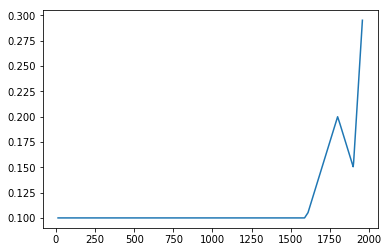

In [16]:
x = (k + np.dot(A, delta))*t_n + (m + np.dot(A, -changepoints_t * delta))
plt.plot(t, x);

### Custom mean function

We could encode this mean function directly, but if we wrap it inside of a `Mean` object, then it easier to use other Gaussian process functionality, like the `.conditional` and `.predict` methods.  Look here [for more information on custom mean and covariance functions](https://docs.pymc.io/notebooks/GP-MeansAndCovs.html#Defining-a-custom-mean-function).  We only need to define `__init__` and `__call__` functions. 

In [17]:
class PeicewiseLinear(pm.gp.mean.Mean):
    def __init__(self, changepoints, k, m, delta):
        self.changepoints = changepoints
        self.k = k
        self.m = m
        self.delta = delta
    
    def __call__(self, X):
        # X are the x locations, or time points
        A = dm_changepoints_theano(X, self.changepoints)
        return (self.k + tt.dot(A, self.delta))*X.flatten() + (self.m + tt.dot(A, -self.changepoints * self.delta))

It is inefficient to recreate `A` every time the mean function is evaluated, but we'll need to do this when the number of inputs changes when making predictions.

Next is the updated model with the changepoint mean function.  Like Prophet, we use a heavy tailed `Laplace` prior on the slope parameters.

In [18]:
with pm.Model() as model:
    η = pm.HalfNormal("η", sd=5)
    ℓ = pm.Gamma("ℓ", alpha=2, beta=0.25)
    cov = η**2 * pm.gp.cov.Matern32(1, ℓ)
    
    # peicewise linear mean function
    k = pm.Normal("k", mu=0, sd=2)
    m = pm.Normal("m", mu=0, sd=2)
    delta = pm.Laplace("delta", mu=0, b=1, shape=len(changepoints_t))
    mean = PeicewiseLinear(changepoints_t, k, m, delta)   

    # include mean function in GP constructor
    gp = pm.gp.Marginal(cov_func=cov, mean_func=mean)
    
    # x location uncertainty (sd = 0.01 is a standard deviation of one year)
    t_diff = pm.Normal("t_diff", mu=0.0, sd=0.01, shape=len(t))
    t_uncert = t_n - t_diff
    
    # white noise variance
    σ = pm.HalfNormal("σ", sd=5, testval=1)
    y_ = gp.marginal_likelihood("y", X=t_uncert[:,None], y=y_n, noise=σ)

In [19]:
with model:
    tr = pm.sample(500, chains=2, cores=1, nuts_kwargs={"target_accept":0.95})

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (2 chains in 1 job)
NUTS: [σ, t_diff, delta, m, k, ℓ, η]
100%|██████████| 1000/1000 [03:10<00:00,  5.24it/s]
There were 1 divergences after tuning. Increase `target_accept` or reparameterize.
There were 1 divergences after tuning. Increase `target_accept` or reparameterize.
The estimated number of effective samples is smaller than 200 for some parameters.


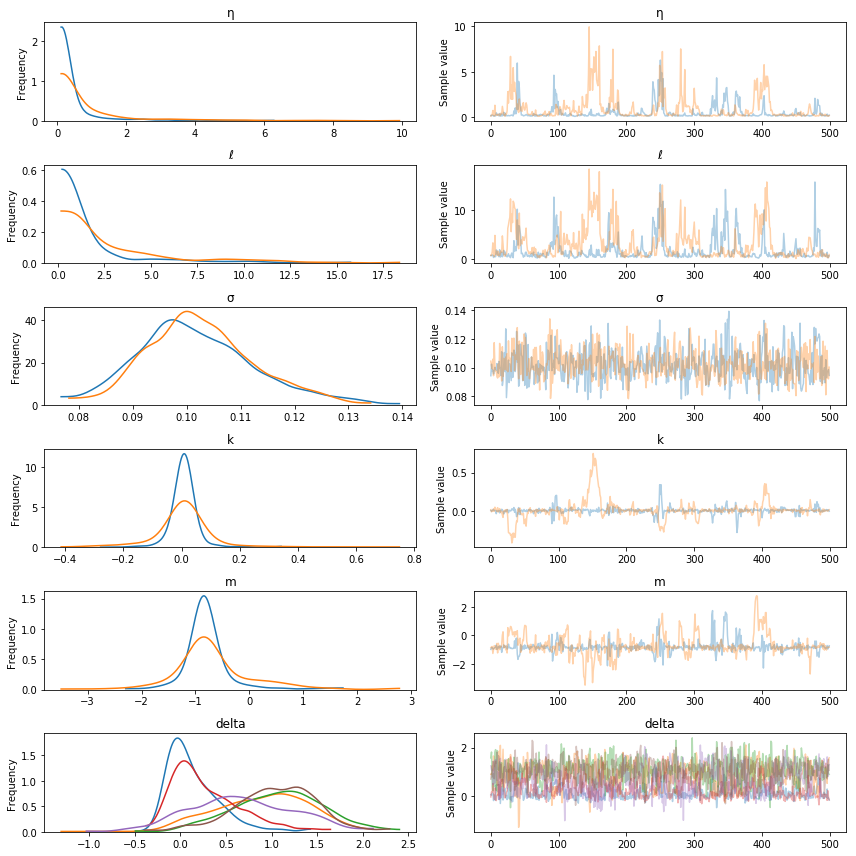

In [20]:
pm.traceplot(tr, varnames=["η", "ℓ", "σ", "k", "m", "delta"]);

### Predictions

In [21]:
tnew = np.linspace(-100, 2200, 2000)/100

with model:
    fnew = gp.conditional("fnew", Xnew=tnew[:,None])
    
with model:
    ppc = pm.sample_ppc(tr, samples=500, vars=[fnew])

100%|██████████| 500/500 [02:30<00:00,  3.31it/s]


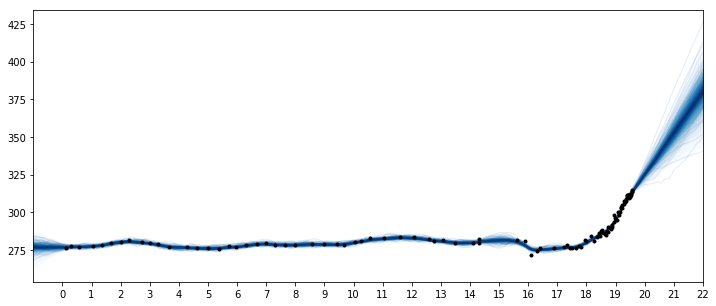

In [22]:
samples = y_sd * ppc["fnew"] + y_mu

fig = plt.figure(figsize=(12,5))
ax = plt.gca()
pm.gp.util.plot_gp_dist(ax, samples, tnew, plot_samples=True, palette="Blues")
ax.plot(t/100, y, "k.");
ax.set_xticks(np.arange(0,23));
ax.set_xlim([-1, 22]);

These results look better.  But at what times should the changepoints be at?  Instead of using a changepoint in the mean function, we can also specify this behavior as a covariance function.  One benefit of the latter formulation is that the changepoint can be a more realistic smooth transition, instead of a discrete breakpoint.  In the next section, we'll look at how to do this, and then bring these things together to combine the ice core data with the Mauna Loa dataset.  We'll be able to produce realistic forecasts, and backcast the seasonality.